---
Pedro Henrique Costa Ribeiro

email: pedrohenriquecostaribeiro@gmail.com

---

# Análise de dados de supernova do tipo Ia

O objetivo deste notebook é estimar alguns dos principais parâmetros cosmológicos com um conjunto de dados coletados de supernovas do tipo Ia (SnIa). Para isso, será necessário cumprir as seguintes etapas:

- Importar a biblioteca NumCosmo e bibliotecas de matemática
- Montar um modelo cosmológico com energia escura
- Selecionar os dados que serão utilizados no ajuste
- Utilizar as ferramentas estatísticas da NumCosmo para ajustar os parâmetros


# 1) Importando as bibliotecas

Primeiro, iremos realizar a importação das bibliotecas NumCosmo - onde estão definidos os diversos modelos e estruturas da cosmologia - e NumCosmoMath, que contém ferramentas matemáticas e estatísticas para os cálculos e integrações. Também é necessário importar o "GObject" para permitir a utilização das biblitecas NumCosmo na linguagem Python.

In [2]:
try:
  import gi
  gi.require_version('NumCosmo', '1.0')
  gi.require_version('NumCosmoMath', '1.0')
except:
  pass

from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

Em seguida, iremos importar algumas bibliotecas de matemática para auxiliar na organização e visualização das variáveis.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sys
%matplotlib inline
import math
import time
plt.rcParams['text.usetex'] = True

import ipywidgets as widgets
from ipywidgets import interactive
from ipywidgets import FloatSlider

Para iniciar a Numcosmo, é importante que seu primeiro comando seja iniciar a biblioteca e direcionar seu output para o próprio notebook que estamos usando; isso é feito por meio dos códigos abaixo.

In [4]:
Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

# 2) Iniciando o modelo cosmológico

Na próxima etapa, criaremos um novo objeto da classe de modelos cosmológicos. Utilizaremos o modelo "DEXcdm" - que significa um modelo que implementa *Dark Energy* (DE), com equação de estado constante (X) e com a matéria escura sendo majoritariamente fria (cdm).

In [5]:
cosmo = Nc.HICosmoDEXcdm.new()

É possível também trocar os parâmetros do modelo. Ao invés de a energia escura ser um parâmetro inicial do modelo cosmológico, podemos trocar para o parâmetro de curvatura ($\Omega_\kappa$). Isso nos permite escolher a curvatura como um dos parâmetros para ser ajustado com os dados. Contudo, essa troca também é útil em uma situação na qual a densidade de energia escura não será ajustada. 

Por exemplo, caso seja decidido ajustar em conjunto a densidade de matéria escura ($\Omega_c$) e a equação de estado da energia escura (W), então não há necessidade da densidade de energia escura ($\Omega_\Lambda$) ser um dos parâmetros iniciais do modelo. Podemos, na verdade, trocá-la pela curvatura e impor $\Omega_\kappa = 0$, realizando nosso ajuste em um universo plano.

Importante estar claro que somente uma das duas ($\Omega_\Lambda$ e $\Omega_\kappa$) pode ser um parâmetro inicial, pois essas densidades estam conectadas pela equação:

$$1 + \Omega_{\kappa0} = \Omega_{b0} + \Omega_{c0} + \Omega_{r0} + \Omega_{\Lambda0}$$

In [6]:
cosmo.omega_x2omega_k()
cosmo.param_set_by_name("Omegak", 0)

Será necessário também criar um objeto da classe "Model Set" para definir os parâmetros que estarão livres para o ajuste. Inicialmente, a densidade de matéria escura e equação de estado da energia escura serão deixados como parâmetros livres.

In [7]:
mset = Ncm.MSet()
mset.set(cosmo)

cosmo.props.Omegac_fit = True
# cosmo.props.Omegax_fit = True
cosmo.props.w_fit = True

Esse objeto também pode ser utilizado para visualizar os valores iniciais dos parâmetros de nossa classe.

In [8]:
mset.pretty_log()

#----------------------------------------------------------------------------------
# Model[03000]:
#   - NcHICosmo : XCDM - Constant EOS
#----------------------------------------------------------------------------------
# Model parameters
#   -      H0[00]:  67.36               [FIXED]
#   -  Omegac[01]:  0.2568              [FIXED]
#   -  Omegak[02]:  0                   [FIXED]
#   - Tgamma0[03]:  2.7245              [FIXED]
#   -      Yp[04]:  0.24                [FIXED]
#   -    ENnu[05]:  3.046               [FIXED]
#   -  Omegab[06]:  0.0432              [FIXED]
#   -       w[07]: -1                   [FIXED]


Por fim, iniciaremos um objeto de cálculo das distâncias cosmológicas que será necessário para iniciar o conjunto de dados. Iremos preparar o objeto para otimizar os cálculos até uma distância z = 5.

In [9]:
dist = Nc.Distance.new(5.0)

# 3) Dados de SNIa

Agora iremos selecionar um dos conjuntos de dados de supernova Ia. Os ajustes foram realizados utilizando o catálogo  "Simple_Legacy" e o "Simple_Union2_1", para adicionar outro catálogo do tipo 'simples' (somente com os erros da própria supernova, ou seja, a matriz de covariância é diagonal), basta trocar a identificação do dados dentro do parenteses. Por padrão, utilizaremos o catálogo <i>Legacy<i>.

In [10]:
legacy = Nc.DataDistMu.new_from_id (dist, Nc.DataSNIAId.SIMPLE_LEGACY)
# union = Nc.DataDistMu.new_from_id (dist, Nc.DataSNIAId.SIMPLE_UNION2_1)
# sdss = Nc.DataDistMu.new_from_id (dist, Nc.DataSNIAId.SIMPLE_SDSS_EMILLE)   # Não está funcionando


In [11]:
dset = Ncm.Dataset ()
dset.append_data (legacy)
# dset.append_data (union)
# dset.append_data (sdss)

# 4) Ajuste dos dados

Utilizaremos os dados coletados do catálogo selecionado para montar nosso objeto de <i>Likelihood<\i>. Com ele e nosso objeto do modelo cosmológico (mset), construiremos um objeto da classe "Fit" (ajuste), com uma otimização não linear (NLOPT), usando o algoritmo "ln-neldermead" e com um método de diferenciação numérica (NUMDIFF_FORWARD).

In [12]:
lh = Ncm.Likelihood (dataset = dset)
fit = Ncm.Fit.new (Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_FORWARD)

Com o objeto de ajuste configurado, basta executar os comandos abaixo para que ele encontre o melhor ajuste dos parâmetros e imprima as informações relevantes.

In [24]:
fit.run (Ncm.FitRunMsgs.SIMPLE)
fit.log_info ()
fit.numdiff_m2lnL_covar ()
fit.log_covar ()

#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (forward)
#...........
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:00.2890630
#  iteration            [000026]
#  function evaluations [000028]
#  gradient evaluations [000000]
#  degrees of freedom   [000112]
#  m2lnL     =     110.972605122063 (     110.97261 )
#  Fit parameters:
#     0.248490782755613   -1.07994421590119    
#----------------------------------------------------------------------------------
# Data used:
#   - Legacy sample
#----------------------------------------------------------------------------------
# Model[03000]:
#   - NcHICosmo : XCDM - Constant EOS
#----------------------------------------------------------------------------------
# Model parameters
#   -      H0[00]:  67.36     

Após determinar o melhor ajuste, podemos ainda querer uma região de confiança para estudar o comportamento desse ajuste em conjunto no espaço paramétrico. Para isso, utilizaremos a classe "LHRatio2d", que utilizará o teste da razão de verossimilhança generalizada para montar um perfil de <i>likelihood</i>, ou seja, um contorno no espaço dos dois parâmetros.

In [15]:
p1 = Ncm.MSetPIndex.new (cosmo.id (), Nc.HICosmoDESParams.OMEGA_C)
# p2 = Ncm.MSetPIndex.new (cosmo.id (), Nc.HICosmoDESParams.OMEGA_X)
p2 = Ncm.MSetPIndex.new (cosmo.id (), Nc.HICosmoDEXCDMSParams.W)

lhr2d = Ncm.LHRatio2d.new (fit, p1, p2, 1.0e-3)

Iremos também cronometrar o tempo gasto pelo método de perfil de <i>likelihood</i>. A região de confiança será montada para uma probabilidade de 68.27%, equivalente a 1 $\sigma$.

In [16]:
t1 = time.time()

cr_rg = lhr2d.conf_region (0.6827, 300.0, Ncm.FitRunMsgs.SIMPLE)

cr_p1array = cr_rg.p1.dup_array ()
cr_p2array = cr_rg.p2.dup_array ()

#----------------------------------------------------------------------------------
# Likelihood ratio confidence region at 68.270%, bestfit [  0.24879709    -1.080826]:
#
#  looking root in interval [           0    1.5151948]:
#.......
#  root found at   0.68302807 with precision 1.00000000e-03.
#  border found at   0.68302807.
#.
#  looking root in interval [   7.0669608    8.6377572]:
#..
#  root found at    8.0320628 with precision 1.00000000e-03.
#  looking root in interval [   7.2466646    8.8174609]:
#...
#  root found at    8.0341874 with precision 1.00000000e-03.
#  looking root in interval [   7.2487893    8.8195856]:
#...
#  root found at    8.0364582 with precision 1.00000000e-03.
#  looking root in interval [   7.2510601    8.8218564]:
#...
#  root found at    8.0387678 with precision 1.00000000e-03.
#  looking root in interval [   7.2533697     8.824166]:
#...
#  root found at    8.0411505 with precision 1.00000000e-03.
#  looking root in interval [   7.2557523    8.8265

#  looking root in interval [    9.433338    11.004134]:
#..
#  root found at    10.265959 with precision 1.00000000e-03.
#  looking root in interval [   9.4805606    11.051357]:
#...
#  root found at    10.307026 with precision 1.00000000e-03.
#  looking root in interval [   9.5216281    11.092424]:
#...
#  root found at    10.340266 with precision 1.00000000e-03.
#  looking root in interval [   9.5548683    11.125665]:
#...
#  root found at    10.369768 with precision 1.00000000e-03.
#  looking root in interval [     9.58437    11.155166]:
#...
#  root found at    10.395576 with precision 1.00000000e-03.
#  looking root in interval [   9.6101777    11.180974]:
#...
#  root found at    10.418357 with precision 1.00000000e-03.
#  looking root in interval [   9.6329585    11.203755]:
#...
#  root found at    10.438628 with precision 1.00000000e-03.
#  looking root in interval [   9.6532298    11.224026]:
#...
#  root found at    10.456797 with precision 1.00000000e-03.
#  looking root i

#  looking root in interval [   9.9413206    11.512117]:
#...
#  root found at    10.728122 with precision 1.00000000e-03.
#  looking root in interval [   9.9427241     11.51352]:
#...
#  root found at    10.729499 with precision 1.00000000e-03.
#  looking root in interval [   9.9441006    11.514897]:
#...
#  root found at    10.730849 with precision 1.00000000e-03.
#  looking root in interval [   9.9454512    11.516248]:
#...
#  root found at    10.732175 with precision 1.00000000e-03.
#  looking root in interval [   9.9467768    11.517573]:
#...
#  root found at    10.733476 with precision 1.00000000e-03.
#  looking root in interval [   9.9480782    11.518875]:
#...
#  root found at    10.734755 with precision 1.00000000e-03.
#  looking root in interval [   9.9493563    11.520153]:
#...
#  root found at     10.73601 with precision 1.00000000e-03.
#  looking root in interval [    9.950612    11.521408]:
#...
#  root found at    10.737244 with precision 1.00000000e-03.
#  looking root 

#  looking root in interval [   10.003994     11.57479]:
#...
#  root found at    10.790136 with precision 1.00000000e-03.
#  looking root in interval [   10.004738    11.575534]:
#...
#  root found at    10.790882 with precision 1.00000000e-03.
#  looking root in interval [   10.005484     11.57628]:
#...
#  root found at     10.79163 with precision 1.00000000e-03.
#  looking root in interval [   10.006231    11.577028]:
#...
#  root found at    10.792379 with precision 1.00000000e-03.
#  looking root in interval [   10.006981    11.577777]:
#...
#  root found at    10.793132 with precision 1.00000000e-03.
#  looking root in interval [   10.007733     11.57853]:
#...
#  root found at    10.793887 with precision 1.00000000e-03.
#  looking root in interval [   10.008489    11.579285]:
#...
#  root found at    10.794645 with precision 1.00000000e-03.
#  looking root in interval [   10.009247    11.580044]:
#...
#  root found at    10.795408 with precision 1.00000000e-03.
#  looking root 

#.....
#  root found at    10.957783 with precision 1.00000000e-03.
#  looking root in interval [   10.172385    11.743182]:
#.....
#  root found at     10.98839 with precision 1.00000000e-03.
#  looking root in interval [   10.202992    11.773788]:
#.....
#  root found at     11.03902 with precision 1.00000000e-03.
#  looking root in interval [   10.253622    11.824418]:
#.....
#  root found at    11.148985 with precision 1.00000000e-03.
#.
#  looking root in interval [   11.934383    13.505179]:
#...
#  root found at    11.976435 with precision 1.00000000e-03.
#.
#  looking root in interval [   12.761833    14.332629]:
#.....
#  root found at    13.390298 with precision 1.00000000e-03.
#  looking root in interval [     12.6049    14.175696]:
#.....
#  root found at    13.572658 with precision 1.00000000e-03.
#  looking root in interval [   12.787259    14.358056]:
#.....
#  root found at    13.638046 with precision 1.00000000e-03.
#  looking root in interval [   12.852648    14.42344

#  looking root in interval [   12.969872    14.540668]:
#...
#  root found at    13.753346 with precision 1.00000000e-03.
#  looking root in interval [   12.967947    14.538744]:
#...
#  root found at    13.751347 with precision 1.00000000e-03.
#  looking root in interval [   12.965949    14.536745]:
#...
#  root found at    13.749271 with precision 1.00000000e-03.
#  looking root in interval [   12.963872    14.534669]:
#...
#  root found at    13.747114 with precision 1.00000000e-03.
#  looking root in interval [   12.961716    14.532512]:
#...
#  root found at    13.744874 with precision 1.00000000e-03.
#  looking root in interval [   12.959476    14.530272]:
#...
#  root found at    13.742548 with precision 1.00000000e-03.
#  looking root in interval [   12.957149    14.527946]:
#...
#  root found at     13.74013 with precision 1.00000000e-03.
#  looking root in interval [   12.954732    14.525529]:
#...
#  root found at    13.737619 with precision 1.00000000e-03.
#  looking root 

#  looking root in interval [   10.976443    12.547239]:
#...
#  root found at    11.709017 with precision 1.00000000e-03.
#  looking root in interval [   10.923619    12.494415]:
#...
#  root found at    11.663382 with precision 1.00000000e-03.
#  looking root in interval [   10.877984    12.448781]:
#..
#  root found at    11.622632 with precision 1.00000000e-03.
#  looking root in interval [   10.837234     12.40803]:
#..
#  root found at    11.589049 with precision 1.00000000e-03.
#  looking root in interval [   10.803651    12.374447]:
#..
#  root found at    11.558276 with precision 1.00000000e-03.
#  looking root in interval [   10.772878    12.343674]:
#..
#  root found at    11.531006 with precision 1.00000000e-03.
#  looking root in interval [   10.745608    12.316404]:
#..
#  root found at    11.506601 with precision 1.00000000e-03.
#  looking root in interval [   10.721203    12.291999]:
#..
#  root found at    11.484657 with precision 1.00000000e-03.
#  looking root in int

#.........
#  root found at    13.964198 with precision 1.00000000e-03.
#  looking root in interval [     13.1788    14.749597]:
#.............
#  root found at    13.951909 with precision 1.00000000e-03.
#  looking root in interval [   13.166511    14.737307]:
#.........
#  root found at    13.964171 with precision 1.00000000e-03.
#  looking root in interval [   13.178773    14.749569]:
#.............
#  root found at     13.95188 with precision 1.00000000e-03.
#  looking root in interval [   13.166482    14.737278]:
#.........
#  root found at    13.964141 with precision 1.00000000e-03.
#  looking root in interval [   13.178743    14.749539]:
#.........
#  root found at    13.976402 with precision 1.00000000e-03.
#  looking root in interval [   13.191004      14.7618]:
#............
#  root found at    13.939567 with precision 1.00000000e-03.
#  looking root in interval [   13.154169    14.724965]:
#..........
#  root found at     13.97637 with precision 1.00000000e-03.
#  looking ro

#...
#  root found at    14.267712 with precision 1.00000000e-03.
#  looking root in interval [   13.482313     15.05311]:
#...
#  root found at    14.268728 with precision 1.00000000e-03.
#  looking root in interval [    13.48333    15.054126]:
#...
#  root found at    14.269764 with precision 1.00000000e-03.
#  looking root in interval [   13.484366    15.055162]:
#...
#  root found at     14.27082 with precision 1.00000000e-03.
#  looking root in interval [   13.485422    15.056218]:
#...
#  root found at    14.271896 with precision 1.00000000e-03.
#  looking root in interval [   13.486498    15.057294]:
#...
#  root found at    14.272994 with precision 1.00000000e-03.
#  looking root in interval [   13.487595    15.058392]:
#...
#  root found at    14.274113 with precision 1.00000000e-03.
#  looking root in interval [   13.488715    15.059511]:
#...
#  root found at    14.275255 with precision 1.00000000e-03.
#  looking root in interval [   13.489857    15.060653]:
#...
#  root fou

In [27]:
t2 = time.time()

fisher_rg = lhr2d.fisher_border (0.6827, 300.0, Ncm.FitRunMsgs.SIMPLE)
fisher_p1array = fisher_rg.p1.dup_array ()
fisher_p2array = fisher_rg.p2.dup_array ()

t3 = time.time()

print(f"Tempo de execução: {t2-t1:.2f} segundos.\n\nEquivalente a {(t2-t1)/60 :.2f} minutos.")

Tempo de execução: 2398.27 segundos.

Equivalente a 39.97 minutos


## Gráfico da região de Confiança

Por fim, utilizaremos as matrizes montadas acima para montar em um gráfico a região de confiança. O contorno desenhado significa que, com base nos dados do catálogo, a probabilidade dos parâmetros estarem dentro dessa região é maior que 68.27%.

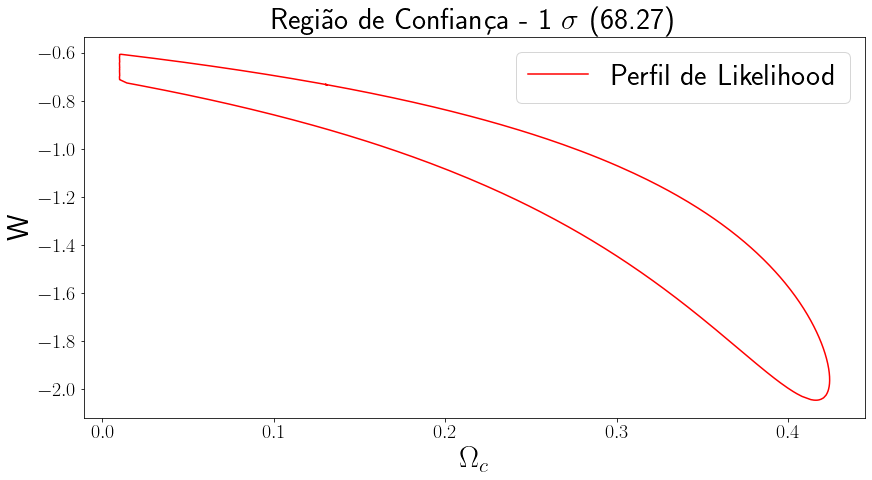

In [28]:
plt.figure (figsize=(14, 7))
plt.title (r"Região de Confiança - 1 $\sigma$ (%.2f)" % (cr_rg.clevel * 100.0), fontsize=30)
plt.plot (cr_p1array, cr_p2array, 'r', label="Perfil de Likelihood")
# plt.plot (fisher_p1array, fisher_p2array, 'b-', label="Fisher Matrix")

plt.xlabel('$\Omega_c$', fontsize=30)
plt.ylabel('W', fontsize=30)
plt.tick_params(labelsize=20)

plt.legend(loc="best", fontsize=30)
plt.savefig("LEGACY_C_W_plano.pdf")
plt.show()
# plt.close()